## DengAI competition
The goal of this competition is to build a model that predicts the number of Dengue cases in San Juan and Iquitos

- [X] Create a time split 80 - 20 per city (there are more years to train and predict for sj than iq)
- [X] Create a basic baseline model with all features 'as is' (bad performance expected)
- [X] Create a basic model only non-correlated features
- [X] One model per city (another notebook)
- [X] Normalize features
- [X] Obtain feature importance
- [ ] Implement time delay using moving averages (another notebook)

In [71]:
import pandas as pd
import os
import seaborn as sns
from dateutil import parser
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
import numpy as np
import hydra
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

### Load data

In [72]:
data_folder = 'data'
features_train_path = 'dengue_features_train.csv'
labels_train_path = 'dengue_labels_train.csv'
features_test_path = 'dengue_features_test.csv'

In [73]:
features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
features_test = pd.read_csv(os.path.join(data_folder, features_test_path))

### Basic Pre-processing

In [74]:
# transform week_start_date into a datetime feature
features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)

  0%|          | 0/1456 [00:00<?, ?it/s]

In [75]:
# Merge features and labels for easier exploration
train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])

In [76]:
def fill_ma(df, col):
    df[col+'_MA'] =  df[col].fillna(df[col].mean()).rolling(2).mean().tolist()
    df[col] = df.apply(lambda x: x[col] if not np.isnan(x[col]) else x[col+'_MA'], axis=1)
    df.drop(columns=[col+'_MA'], inplace=True)

In [77]:
fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
for col in tqdm(fill_ma_cols):
#     fill_ma(train_df, col)
    train_df[col].fillna(method='ffill', inplace=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [78]:
train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)

### Split train - eval by date

In [79]:
iq_train_years = sorted(train_df[train_df.city == 'iq']['year'].drop_duplicates().values)[:int(train_df[train_df.city == 'iq']['year'].nunique() * 0.8)]
iq_eval_years = sorted(train_df[train_df.city == 'iq']['year'].drop_duplicates().values)[int(train_df[train_df.city == 'iq']['year'].nunique() * 0.8):]
sj_train_years = sorted(train_df[train_df.city == 'sj']['year'].drop_duplicates().values)[:int(train_df[train_df.city == 'sj']['year'].nunique() * 0.8)]
sj_eval_years = sorted(train_df[train_df.city == 'sj']['year'].drop_duplicates().values)[int(train_df[train_df.city == 'sj']['year'].nunique() * 0.8):]

In [80]:
eval_df = train_df[(train_df.city == 'sj') & (train_df.year.isin(sj_eval_years)) | (train_df.city == 'iq') & (train_df.year.isin(iq_eval_years))]
train_df = train_df[(train_df.city == 'sj') & (train_df.year.isin(sj_train_years)) | (train_df.city == 'iq') & (train_df.year.isin(iq_train_years))]

In [12]:
eval_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
763,sj,2005,0,2005-01-01,-0.126100,-0.062967,0.199486,0.140350,150.31,298.682857,...,83.952857,150.31,17.148571,2.057143,26.242857,5.714286,30.0,22.8,55.7,10
764,sj,2005,1,2005-01-08,0.007900,-0.049633,0.124657,0.100443,0.00,297.587143,...,74.778571,0.00,14.261429,1.957143,24.985714,4.900000,28.3,21.1,23.8,15
765,sj,2005,2,2005-01-15,0.024350,-0.019275,0.133543,0.127243,0.00,297.600000,...,78.798571,0.00,15.042857,1.914286,25.200000,5.385714,28.3,22.2,55.6,17
766,sj,2005,3,2005-01-22,-0.111833,-0.076450,0.202900,0.223357,14.67,297.395714,...,83.055714,14.67,15.671429,1.914286,25.228571,4.914286,28.3,21.7,32.4,7
767,sj,2005,4,2005-01-29,-0.047900,0.043100,0.174300,0.145643,15.20,296.535714,...,78.538571,15.20,14.091429,2.657143,23.757143,6.328571,28.3,17.8,34.0,7


In [13]:
train_df.shape

(1153, 25)

In [14]:
list(train_df.select_dtypes(include=np.number).columns)

['year',
 'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [15]:
[col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)]

['city', 'week_start_date']

In [16]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in list(train_df.select_dtypes(include=np.number).columns) if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [17]:
num_cols

['year',
 'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

In [18]:
cat_cols

['city']

In [19]:
train_cat_df = pd.get_dummies(train_df[cat_cols])

In [21]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
label_train = train_df[TARGET]
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
label_eval = eval_df[TARGET]

In [22]:
model = 'sklearn.svm.SVR'

In [23]:
clf = hydra.utils.get_class(model)(kernel='linear')

In [24]:
clf = clf.fit(features_train, label_train)

In [25]:
y_hat = clf.predict(features_eval)

In [26]:
mean_absolute_error(label_eval, y_hat)

14.737457206609562

### Only non-correlated features

In [27]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
 'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [28]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [51]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
feature_names = list(features_train.columns)
features_train = features_train.values
label_train = train_df[TARGET].values
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols])).values
label_eval = eval_df[TARGET].values

In [52]:
model = 'sklearn.svm.SVR'

In [53]:
clf = hydra.utils.get_class(model)(kernel='linear')

In [39]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True)

In [54]:
clf = clf.fit(features_train, label_train)

In [55]:
y_hat = clf.predict(features_eval)

In [56]:
mean_absolute_error(label_eval, y_hat)

14.755264902996284

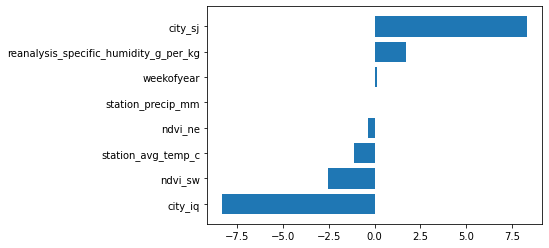

In [57]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(clf.coef_[0], feature_names)

### One model per city

In [58]:
initial_list = [
    'weekofyear',
#  'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
#  'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [120]:
y_real = []
y_pred = []
for city in ['sj', 'iq']:
    features_train = pd.read_csv(os.path.join(data_folder, features_train_path))
    labels_train = pd.read_csv(os.path.join(data_folder, labels_train_path))
    features_test = pd.read_csv(os.path.join(data_folder, features_test_path))
    # transform week_start_date into a datetime feature
    
    features_train['week_start_date'] = features_train.progress_apply(lambda x: parser.parse(x.week_start_date), axis=1)
    
    # Merge features and labels for easier exploration
    train_df = features_train.merge(labels_train, on=['city', 'year', 'weekofyear'])
    
    fill_ma_cols = [col for col in train_df.columns if train_df[train_df[col].isna()].shape[0] > 0]
    for col in tqdm(fill_ma_cols):
        fill_ma(train_df, col)
    train_df['weekofyear'] = train_df.apply(lambda x: x.weekofyear if x.weekofyear != 53 else 0, axis=1)
    train_years = sorted(train_df[train_df.city == city]['year'].drop_duplicates().values)[:int(train_df[train_df.city == city]['year'].nunique() * 0.8)]
    eval_years = sorted(train_df[train_df.city == city]['year'].drop_duplicates().values)[int(train_df[train_df.city == city]['year'].nunique() * 0.8):]

    eval_df = train_df[(train_df.city == city) & (train_df.year.isin(eval_years))]
    train_df = train_df[(train_df.city == city) & (train_df.year.isin(train_years))]
    
    TARGET = 'total_cases'
    ignore_cols = ['week_start_date'] + [TARGET]
    num_cols = [col for col in initial_list if col not in ignore_cols]
    
    features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
    label_train = train_df[TARGET]
    features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
    label_eval = eval_df[TARGET]
    
    model = 'sklearn.svm.SVR'
    clf = hydra.utils.get_class(model)(kernel='linear')
    clf = clf.fit(features_train, label_train)
    y_hat = clf.predict(features_eval)
    y_pred.extend(y_hat)
    y_real.extend(label_eval)
    print(city, mean_absolute_error(label_eval, y_hat))
print(mean_absolute_error(y_real, y_pred))

  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

sj 18.662644849221383


  0%|          | 0/1456 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

iq 8.096945478056925
14.129506505157424


### Scaled features

In [81]:
initial_list = [
    'weekofyear',
 'ndvi_ne',
#  'ndvi_nw',
#  'ndvi_se',
 'ndvi_sw',
#  'precipitation_amt_mm',
#  'reanalysis_air_temp_k',
#  'reanalysis_avg_temp_k',
#  'reanalysis_dew_point_temp_k',
#  'reanalysis_max_air_temp_k',
#  'reanalysis_min_air_temp_k',
#  'reanalysis_precip_amt_kg_per_m2',
#  'reanalysis_relative_humidity_percent',
#  'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
#  'reanalysis_tdtr_k',
 'station_avg_temp_c',
#  'station_diur_temp_rng_c',
#  'station_max_temp_c',
#  'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

In [82]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [83]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
label_train = train_df[TARGET]
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols]))
label_eval = eval_df[TARGET]

In [84]:
scaler = preprocessing.StandardScaler().fit(features_train)
# scaler = preprocessing.MinMaxScaler().fit(features_train)

In [85]:
features_train = scaler.transform(features_train)
features_eval = scaler.transform(features_eval)
#scaler = preprocessing.MinMaxScaler().fit(features_train)
#features_train = scaler.transform(features_train)
#features_eval = scaler.transform(features_eval)

In [86]:
model = 'sklearn.svm.SVR'

In [87]:
clf = hydra.utils.get_class(model)()#(kernel='linear')

In [57]:
model = 'sklearn.neural_network.MLPRegressor'
clf = hydra.utils.get_class(model)(hidden_layer_sizes=(8,4,), early_stopping=True)

In [88]:
clf = clf.fit(features_train, label_train)

In [89]:
y_hat = clf.predict(features_eval)

In [90]:
mean_absolute_error(label_eval, y_hat)

13.614313871299462

## Scaled all features

In [91]:
initial_list = [
    'weekofyear',
     'ndvi_ne',
     'ndvi_nw',
     'ndvi_se',
     'ndvi_sw',
     'precipitation_amt_mm',
     'reanalysis_air_temp_k',
     'reanalysis_avg_temp_k',
     'reanalysis_dew_point_temp_k',
     'reanalysis_max_air_temp_k',
     'reanalysis_min_air_temp_k',
     'reanalysis_precip_amt_kg_per_m2',
     'reanalysis_relative_humidity_percent',
     'reanalysis_sat_precip_amt_mm',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_tdtr_k',
     'station_avg_temp_c',
     'station_diur_temp_rng_c',
     'station_max_temp_c',
     'station_min_temp_c',
     'station_precip_mm',
     'total_cases']

In [92]:
TARGET = 'total_cases'
ignore_cols = ['week_start_date'] + [TARGET]
num_cols = [col for col in initial_list if col not in ignore_cols]
cat_cols = [col for col in [col for col in train_df.columns if col not in list(train_df.select_dtypes(include=np.number).columns)] if col not in ignore_cols]

In [106]:
features_train = train_df[num_cols].join(pd.get_dummies(train_df[cat_cols]))
feature_names = list(features_train.columns)
features_train = features_train.values
label_train = train_df[TARGET].values
features_eval = eval_df[num_cols].join(pd.get_dummies(eval_df[cat_cols])).values
label_eval = eval_df[TARGET].values

In [107]:
scaler = preprocessing.StandardScaler().fit(features_train)

In [108]:
features_train = scaler.transform(features_train)
features_eval = scaler.transform(features_eval)

In [109]:
model = 'sklearn.svm.SVR'

In [110]:
clf = hydra.utils.get_class(model)(kernel='linear')

In [111]:
clf = clf.fit(features_train, label_train)

In [112]:
y_hat = clf.predict(features_eval)

In [117]:
mean_absolute_error(label_eval, [y if y > 0 else 0 for y in y_hat])

14.54596906304343

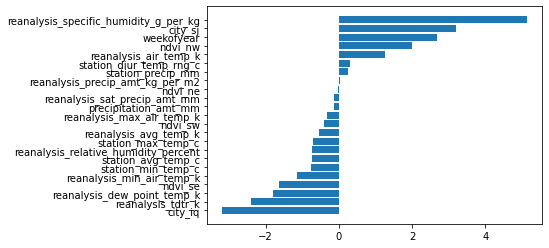

In [118]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
f_importances(clf.coef_[0], feature_names)

Initially, both splitting by city and scalling features seem to positively affect the predictions.

Selecting best features also seems to have a positive impact

Next, we should try other models and generate some features using Moving Averages and Shifting